In [1]:
!pip install kaggle

In [2]:

from google.colab import files
files.upload()




Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username": "AbinayaB04", "key": "KGAT_ceec7b63217294cd9e537d0a9135b5e3"}'}

In [3]:
import os

In [4]:
os.makedirs('/root/.kaggle',exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images


Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 90% 94.0M/105M [00:00<00:00, 972MB/s]
100% 105M/105M [00:00<00:00, 919MB/s] 


In [7]:
import zipfile
with zipfile.ZipFile('cifake-real-and-ai-generated-synthetic-images.zip', 'r') as zip_ref:
    zip_ref.extractall('./cifake')

In [8]:
for root, dirs, files in os.walk('./cifake'):
  level=root.replace('./cifake','').count(os.sep)
  indent=' '*2*level
  print(f'{indent}{os.path.basename(root)}/')
  if level==2:
    print(f'{indent}--> {len(files)} images')

cifake/
  test/
    REAL/
    --> 10000 images
    FAKE/
    --> 10000 images
  train/
    REAL/
    --> 50000 images
    FAKE/
    --> 50000 images


In [9]:
import torch
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,random_split

In [10]:
train_transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.3,0.3,0.3])
])

test_transform=transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.3,0.3,0.3])
]
)

In [11]:
#loading dataset
DATA_DIRECTORY='./cifake'
train_dataset=datasets.ImageFolder(root=f'{DATA_DIRECTORY}/train',transform=train_transform)
test_dataset=datasets.ImageFolder(root=f'{DATA_DIRECTORY}/test',transform=test_transform)
print(f"Classes:{train_dataset.classes}")
print(f"Classes to index:{train_dataset.class_to_idx}")


Classes:['FAKE', 'REAL']
Classes to index:{'FAKE': 0, 'REAL': 1}


In [12]:
#train val split
train_size=int(0.9*len(train_dataset))
val_size=len(train_dataset)-train_size
train_data,val_data=random_split(train_dataset,[train_size,val_size],generator=torch.Generator().manual_seed(42))
print(f"Train size:{len(train_data)}")
print(f"Val size:{len(val_data)}")
print(f"Test size:{len(test_dataset)}")

Train size:90000
Val size:10000
Test size:20000


In [13]:
BATCH_SIZE=64
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=2,pin_memory=True)
test_loader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)
val_loader=DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,pin_memory=True)


In [14]:
import matplotlib.pyplot as plt


In [15]:
images,labels=next(iter(train_loader))
print(f"Image batch shape : {images.shape}")     # (64, 3, 32, 32)
print(f"Label batch shape : {labels.shape}")     # (64,)
print(f"Unique labels     : {labels.unique()}")  # tensor([0, 1])

Image batch shape : torch.Size([64, 3, 32, 32])
Label batch shape : torch.Size([64])
Unique labels     : tensor([0, 1])


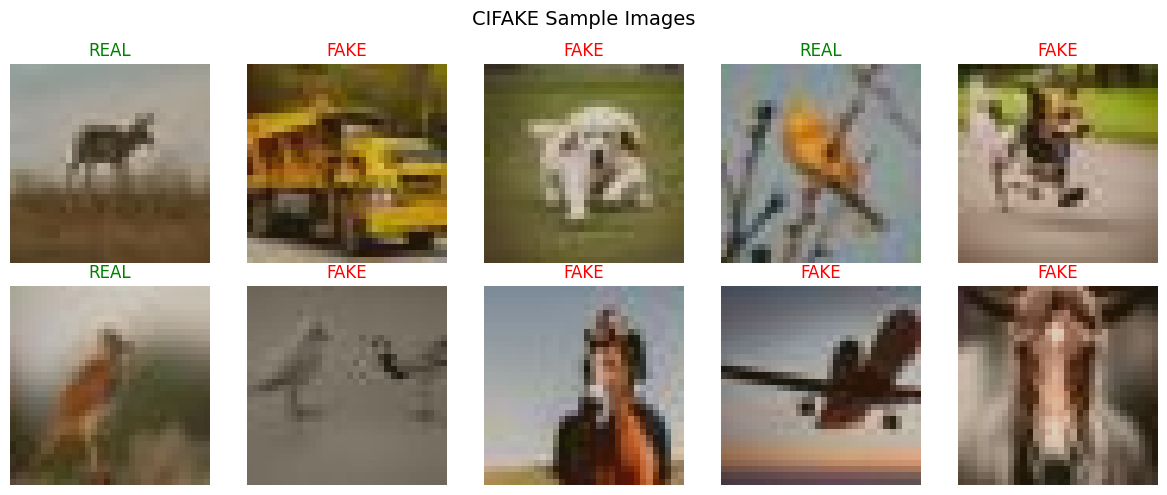

In [16]:
def denormalize(tensor):
    # Get the device of the input tensor (CPU or GPU)
    device = tensor.device

    # Create mean and std on the SAME device as the tensor
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)

    return (tensor * std + mean).clamp(0, 1)
# Plot sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('CIFAKE Sample Images', fontsize=14)

for i, ax in enumerate(axes.flatten()):
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    label = train_dataset.classes[labels[i]]
    ax.imshow(img)
    ax.set_title(label, color='green' if label == 'REAL' else 'red')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import Subset, DataLoader
import random, numpy as np, copy
from torch.backends import cudnn
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve, RocCurveDisplay,
                             precision_recall_curve, average_precision_score, PrecisionRecallDisplay)

# Reproducibility
seed = 123
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
cudnn.deterministic = True
cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [18]:
# 1. Load Pretrained ResNet-50
num_classes = 2 # FAKE and REAL
model_resnet = models.resnet50(weights='IMAGENET1K_V1')

# 2. Fine-tuning strategy: Freeze all but layer4 and fc
for name, param in model_resnet.named_parameters():
    if not (name.startswith('layer4') or name.startswith('fc')):
        param.requires_grad = False

# 3. Replace final layer
in_feats = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_feats, num_classes)
model_resnet = model_resnet.to(device)

# 4. Define Training Function (Named correctly to match your call)
def train_resnet(model, train_loader, val_loader, epochs=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                          lr=1e-3, momentum=0.9, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(epochs):
        model.train()
        run_loss, preds, labels = 0.0, [], []
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            run_loss += loss.item() * x.size(0)
            preds.extend(out.argmax(1).cpu().tolist())
            labels.extend(y.cpu().tolist())

        # Validation phase
        model.eval()
        v_preds, v_labels = [], []
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                v_preds.extend(out.argmax(1).cpu().tolist())
                v_labels.extend(y.cpu().tolist())

        val_acc = accuracy_score(v_labels, v_preds)
        scheduler.step()
        print(f"Epoch {epoch+1}/{epochs} | Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts, "best_resnet_cifake.pth")

    model.load_state_dict(best_model_wts)
    return model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


In [19]:
print("Starting ResNet Fine-tuning...")
model_resnet = train_resnet(model_resnet, train_loader, val_loader, epochs=5)

Starting ResNet Fine-tuning...
Epoch 1/5 | Val Acc: 0.9189
Epoch 2/5 | Val Acc: 0.9335
Epoch 3/5 | Val Acc: 0.9395
Epoch 4/5 | Val Acc: 0.9368
Epoch 5/5 | Val Acc: 0.9403


Evaluating ResNet-50 on test data...

--- FINAL CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

        FAKE       0.95      0.94      0.94     10000
        REAL       0.94      0.95      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



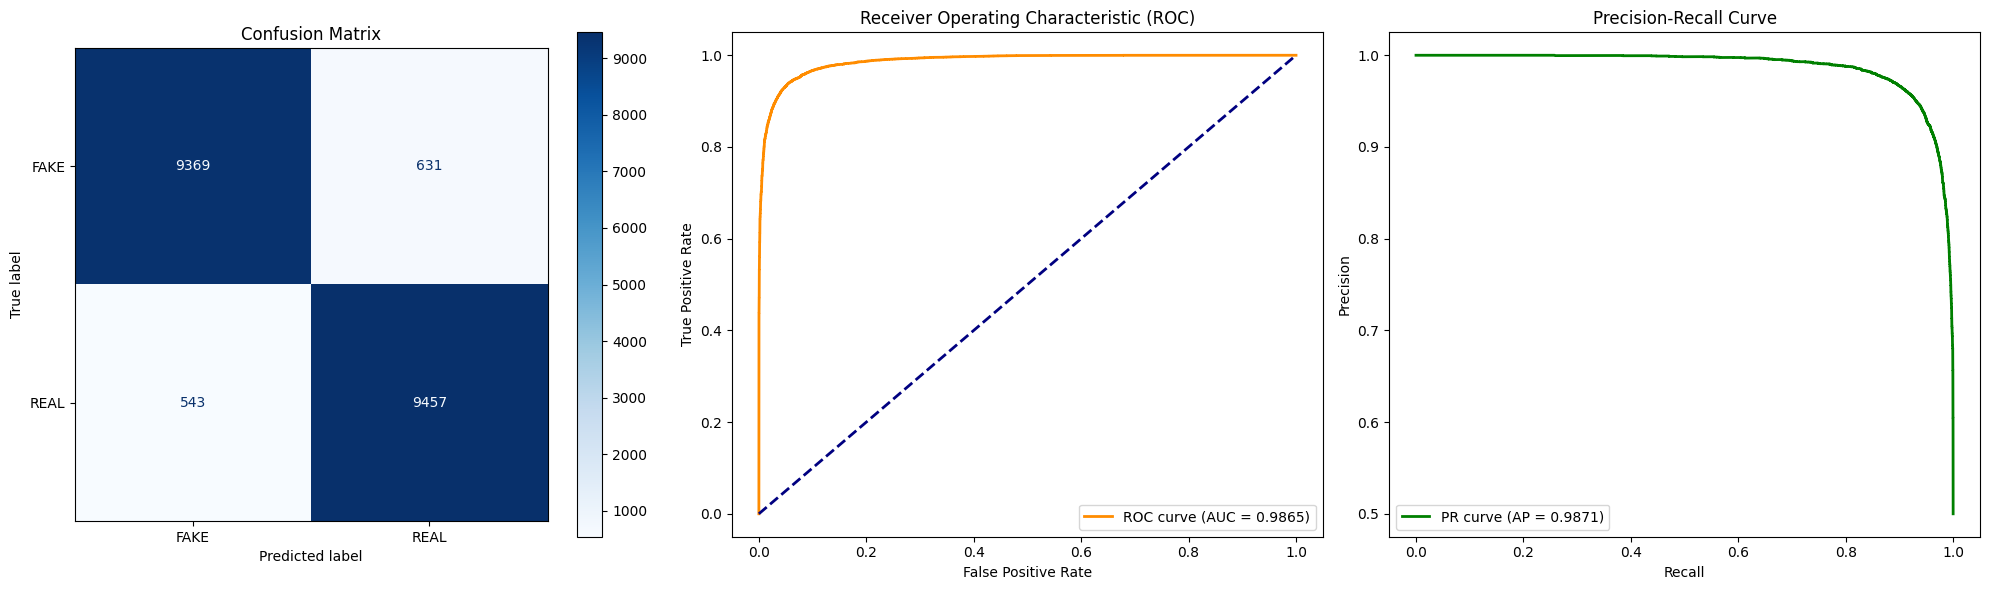

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, auc,
                             precision_recall_curve, average_precision_score)

# 1. Generate Predictions for the Test Set
model_resnet.eval()
all_preds = []
all_labels = []
all_probs = []

print("Evaluating ResNet-50 on test data...")
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        outputs = model_resnet(x)

        # Get probabilities for the 'REAL' class (index 1)
        probs = torch.softmax(outputs, dim=1)

        all_probs.extend(probs[:, 1].cpu().numpy())
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

# 2. Print Classification Metrics
print("\n--- FINAL CLASSIFICATION REPORT ---")
print(classification_report(all_labels, all_preds, target_names=["FAKE", "REAL"]))

# 3. Plot Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["FAKE", "REAL"])
disp.plot(cmap='Blues', ax=ax[0], values_format='d')
ax[0].set_title('Confusion Matrix')

# 4. Plot ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
ax[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
ax[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('Receiver Operating Characteristic (ROC)')
ax[1].legend(loc="lower right")

# 5. Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(all_labels, all_probs)
ap_score = average_precision_score(all_labels, all_probs)
ax[2].plot(recall, precision, color='green', lw=2, label=f'PR curve (AP = {ap_score:.4f})')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Precision-Recall Curve')
ax[2].legend(loc="lower left")

plt.tight_layout()
plt.show()

In [21]:
# SAVING THE MODEL

# 1. Define the filename
MODEL_NAME = "cifake_resnet50_baseline1.pth"

# 2. Save the state_dict (Weights)
# We save the model's 'state_dict' which is the industry standard
torch.save(model_resnet.state_dict(), MODEL_NAME)

print(f"✅ Model weights saved as: {MODEL_NAME}")

# 3. Download the file to your local computer (Google Colab only)
from google.colab import files
files.download(MODEL_NAME)


✅ Model weights saved as: cifake_resnet50_baseline1.pth


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
import torch
import torch.nn as nn
import copy
from torchvision import models

# Must recreate the exact same architecture used during training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = 2

model_resnet = models.resnet50(weights='IMAGENET1K_V1')

# Freeze layers (same as training)
for name, param in model_resnet.named_parameters():
    if not (name.startswith('layer4') or name.startswith('fc')):
        param.requires_grad = False

# Replace final layer (same as training)
in_feats = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_feats, num_classes)

# Load saved weights
model_resnet.load_state_dict(torch.load('cifake_resnet50_baseline1.pth', map_location=device))
model_resnet = model_resnet.to(device)
model_resnet.eval()  # Very important!

print("ResNet-50 loaded successfully!")

ResNet-50 loaded successfully!


In [23]:
from torchvision import transforms
from PIL import Image

# ResNet expects 224x224 — NOT 32x32!
transform = transforms.Compose([
    transforms.Resize((32,32)),         # ResNet standard input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.229, 0.224, 0.225])  # ImageNet stats
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image)
    tensor = tensor.unsqueeze(0)           # (1, 3, 224, 224)
    return tensor

In [25]:
def predict(image_path, model, device, threshold=0.5):
    # Must match your dataset's class_to_idx order
    # ImageFolder loads alphabetically: FAKE=0, REAL=1
    class_names = {0: 'FAKE', 1: 'REAL'}

    image_tensor = preprocess_image(image_path).to(device)

    with torch.no_grad():
        output      = model(image_tensor)          # Raw logits (1, 2)
        probs       = torch.softmax(output, dim=1) # Convert to probabilities
        confidence, predicted_class = torch.max(probs, dim=1)

    label      = class_names[predicted_class.item()]
    confidence = confidence.item()

    print(f"Image          : {image_path}")
    print(f"Prediction     : {label}")
    print(f"Confidence     : {confidence*100:.2f}%")
    print(f"  → FAKE : {probs[0][0].item()*100:.2f}%")
    print(f"  → REAL : {probs[0][1].item()*100:.2f}%")

    return label, confidence

# Run it
label, confidence = predict('/content/_DSC1159.jpg', model_resnet, device)

Image          : /content/_DSC1159.jpg
Prediction     : REAL
Confidence     : 100.00%
  → FAKE : 0.00%
  → REAL : 100.00%


In [26]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 115.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44285 sha256=90022d2e23cc23dd5ef2318e881285ef862304fdb1d5591dd176c70e718dfe3c
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [27]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import models, transforms
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [28]:
def load_image(image_path):
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image).unsqueeze(0)  # (1, 3, 224, 224)
    return image, tensor

In [29]:
def compute_saliency_map(model, image_tensor, device):
    """
    Saliency map: gradient of the predicted class score
    with respect to the input image pixels.
    The higher the gradient, the more that pixel
    influenced the prediction.
    """
    model.eval()
    image_tensor = image_tensor.to(device)
    image_tensor.requires_grad_()  # Enable gradient on input

    output = model(image_tensor)
    probs  = torch.softmax(output, dim=1)
    pred_class = probs.argmax(dim=1).item()

    # Backprop the score of predicted class
    model.zero_grad()
    score = output[0, pred_class]
    score.backward()

    # Take max across color channels
    saliency = image_tensor.grad.data.abs()
    saliency, _ = torch.max(saliency, dim=1)
    saliency = saliency.squeeze().cpu().numpy()

    return saliency, pred_class, probs

In [30]:
def compute_gradcam(model, image_tensor, device):
    """
    Grad-CAM: uses gradients flowing into the last
    convolutional layer to produce a coarse localization
    map highlighting important regions.
    """
    # Target the last conv layer of ResNet-50
    target_layers = [model.layer4[-1]]

    image_tensor = image_tensor.to(device)

    with GradCAM(model=model, target_layers=target_layers) as cam:
        probs        = torch.softmax(model(image_tensor), dim=1)
        pred_class   = probs.argmax(dim=1).item()

        targets      = [ClassifierOutputTarget(pred_class)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0]  # Remove batch dim

    return grayscale_cam, pred_class, probs

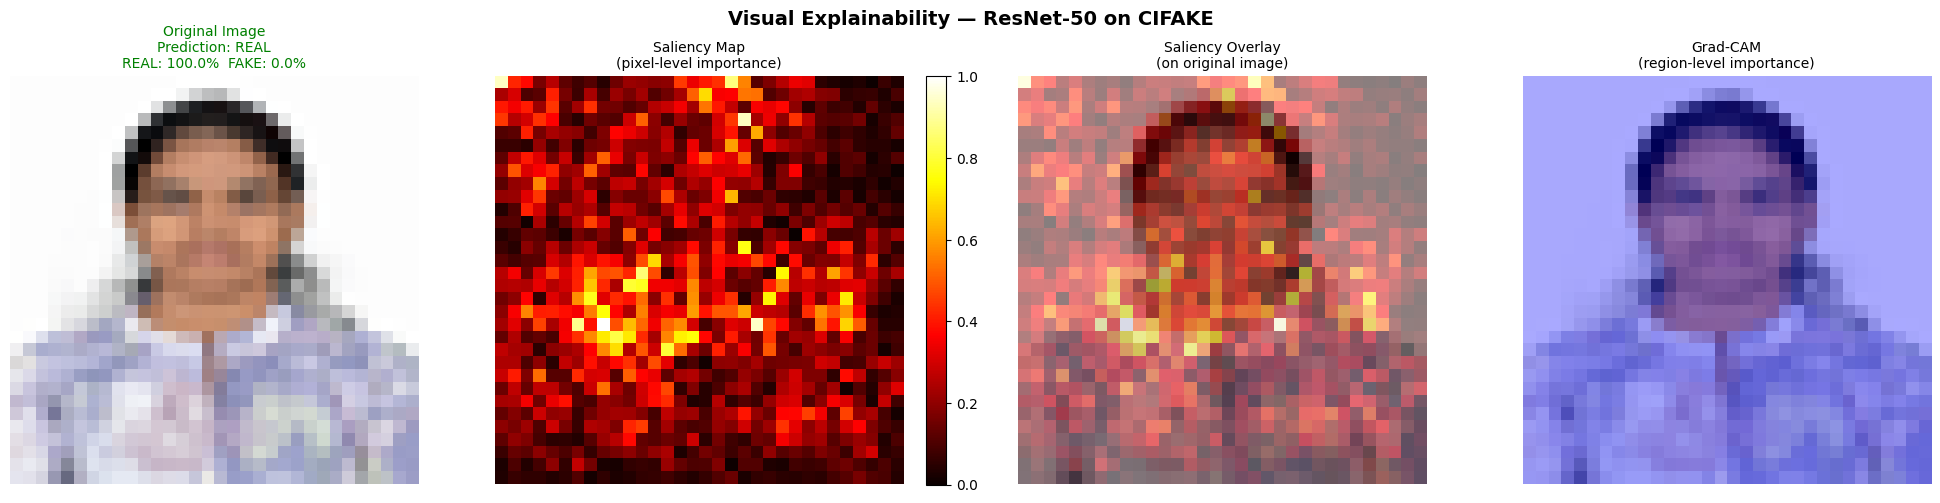


Prediction : REAL
REAL       : 100.00%
FAKE       : 0.00%


In [31]:
def visualize_explainability(image_path, model, device):
    class_names = {0: 'FAKE', 1: 'REAL'}
    colors      = {0: 'red',  1: 'green'}

    # Load image
    original_image, image_tensor = load_image(image_path)
    original_np = np.array(original_image.resize((32,32))) / 255.0  # Normalize to [0,1]

    # ---- Saliency Map ----
    saliency, sal_pred, sal_probs = compute_saliency_map(model,
                                                          image_tensor.clone(),
                                                          device)

    # ---- Grad-CAM ----
    gradcam, cam_pred, cam_probs = compute_gradcam(model,
                                                    image_tensor.clone(),
                                                    device)

    # Overlay Grad-CAM on original image
    gradcam_overlay = show_cam_on_image(original_np.astype(np.float32),
                                        gradcam,
                                        use_rgb=True)

    # ---- Plot ----
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f"Visual Explainability — ResNet-50 on CIFAKE",
                 fontsize=14, fontweight='bold')

    # 1. Original Image
    axes[0].imshow(original_np)
    pred_label = class_names[cam_pred]
    pred_color = colors[cam_pred]
    axes[0].set_title(f"Original Image\nPrediction: {pred_label}\n"
                      f"REAL: {cam_probs[0][1].item()*100:.1f}%  "
                      f"FAKE: {cam_probs[0][0].item()*100:.1f}%",
                      color=pred_color, fontsize=10)
    axes[0].axis('off')

    # 2. Saliency Map
    axes[1].imshow(saliency, cmap='hot')
    axes[1].set_title("Saliency Map\n(pixel-level importance)", fontsize=10)
    axes[1].axis('off')
    plt.colorbar(cm.ScalarMappable(cmap='hot'), ax=axes[1], fraction=0.046)

    # 3. Saliency Overlay
    saliency_norm = (saliency - saliency.min()) / (saliency.max() - saliency.min())
    saliency_colored = plt.cm.hot(saliency_norm)[:, :, :3]
    overlay = (0.5 * original_np + 0.5 * saliency_colored)
    overlay = np.clip(overlay, 0, 1)
    axes[2].imshow(overlay)
    axes[2].set_title("Saliency Overlay\n(on original image)", fontsize=10)
    axes[2].axis('off')

    # 4. Grad-CAM Overlay
    axes[3].imshow(gradcam_overlay)
    axes[3].set_title("Grad-CAM\n(region-level importance)", fontsize=10)
    axes[3].axis('off')

    plt.tight_layout()
    plt.savefig('explainability_output.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nPrediction : {pred_label}")
    print(f"REAL       : {cam_probs[0][1].item()*100:.2f}%")
    print(f"FAKE       : {cam_probs[0][0].item()*100:.2f}%")

# Run it
visualize_explainability('/content/_DSC1159.jpg', model_resnet, device)

Phase2 breaking the model - frequency domain attack (Spectral Artifact Evasion (via FFT Low-Pass Filtering))

ORIGINAL IMAGE
Image       : /content/cifake/test/FAKE/0.jpg
Prediction  : FAKE
Confidence  : 98.17%
  → FAKE : 98.17%
  → REAL : 1.83%

Searching for evasion threshold...

======= AFTER FREQUENCY (FFT) ATTACK =======
Final Keep Fraction used: 0.15
Image       : temp_fft_image.jpg
Prediction  : REAL
Confidence  : 99.62%
  → FAKE : 0.38%
  → REAL : 99.62%

Prediction FLIPPED due to Frequency attack!
Confidence Change: 98.17% → 99.62%


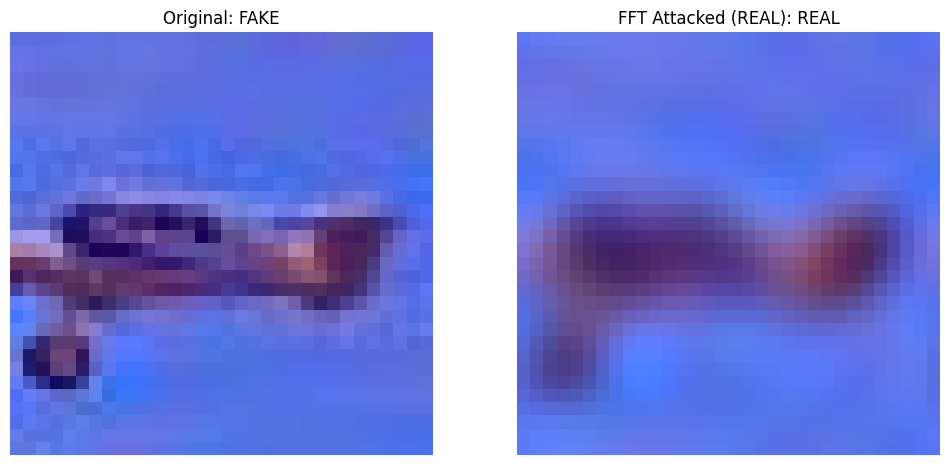

In [45]:
import torch.fft as fft
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image

# ---FFT ATTACK FUNCTION ---
def apply_frequency_attack(image_tensor, keep_fraction=0.15):
    """Surgically removes high-frequency AI fingerprints."""
    image_fft = fft.fft2(image_tensor)
    image_fft_shifted = fft.fftshift(image_fft)

    C, H, W = image_tensor.shape
    mask = torch.zeros_like(image_fft_shifted)
    h_keep, w_keep = int(H * keep_fraction), int(W * keep_fraction)
    center_h, center_w = H // 2, W // 2

    mask[:, center_h - h_keep : center_h + h_keep, center_w - w_keep : center_w + w_keep] = 1

    filtered_fft = image_fft_shifted * mask
    filtered_fft = fft.ifftshift(filtered_fft)
    return fft.ifft2(filtered_fft).real.clamp(-2, 2)

def run_frequency_task_on_file(image_path, model, start_fraction=0.15):
    model.eval()
    class_names = {0: 'FAKE', 1: 'REAL'}

    # Load and Preprocess
    orig_img_pil = Image.open(image_path).convert('RGB')
    input_tensor = transform(orig_img_pil).unsqueeze(0).to(device)

    # --- ORIGINAL PREDICTION ---
    with torch.no_grad():
        out_orig = model(input_tensor)
        probs_orig = torch.softmax(out_orig, dim=1)[0]
        conf_orig, pred_idx_orig = torch.max(probs_orig, dim=0)

    label_orig = class_names[pred_idx_orig.item()]
    cam_orig, _, _ = compute_gradcam(model, input_tensor, device)

    print("ORIGINAL IMAGE")
    print(f"Image       : {image_path}")
    print(f"Prediction  : {label_orig}")
    print(f"Confidence  : {conf_orig.item()*100:.2f}%")
    print(f"  → FAKE : {probs_orig[0].item()*100:.2f}%")
    print(f"  → REAL : {probs_orig[1].item()*100:.2f}%")

    # --- FREQUENCY ATTACK (AUTO-SEARCH FOR FLIP) ---
    # We will decrease keep_fraction until label_attack becomes 'REAL'
    current_frac = start_fraction
    label_attack = label_orig

    print(f"\nSearching for evasion threshold...")

    while label_attack == label_orig and current_frac > 0.02:
        attacked_tensor = apply_frequency_attack(input_tensor.squeeze(0), current_frac).unsqueeze(0).to(device)

        with torch.no_grad():
            out_attack = model(attacked_tensor)
            probs_attack = torch.softmax(out_attack, dim=1)[0]
            conf_attack, pred_idx_attack = torch.max(probs_attack, dim=0)
            label_attack = class_names[pred_idx_attack.item()]

        if label_attack == label_orig:
            current_frac -= 0.02 # Make the filter more aggressive

    # Save temp image of the SUCCESSFUL attack
    attacked_np = denormalize(attacked_tensor.squeeze(0)).permute(1, 2, 0).cpu().numpy()
    attacked_np = (np.clip(attacked_np, 0, 1) * 255).astype(np.uint8)
    temp_path = "temp_fft_image.jpg"
    Image.fromarray(attacked_np).save(temp_path)

    cam_attack, _, _ = compute_gradcam(model, attacked_tensor, device)

    print(f"\n======= AFTER FREQUENCY (FFT) ATTACK =======")
    print(f"Final Keep Fraction used: {current_frac:.2f}")
    print(f"Image       : {temp_path}")
    print(f"Prediction  : {label_attack}")
    print(f"Confidence  : {conf_attack.item()*100:.2f}%")
    print(f"  → FAKE : {probs_attack[0].item()*100:.2f}%")
    print(f"  → REAL : {probs_attack[1].item()*100:.2f}%")

    if label_orig != label_attack:
        print(f"\nPrediction FLIPPED due to Frequency attack!")
        print(f"Confidence Change: {conf_orig.item()*100:.2f}% → {conf_attack.item()*100:.2f}%")
    else:
        print(f"\nPrediction did not flip (Model is extremely robust).")

    # --- GRAD-CAM VISUALIZATION ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    img_orig_np = denormalize(input_tensor.squeeze(0)).permute(1, 2, 0).cpu().numpy()
    axes[0].imshow(show_cam_on_image(img_orig_np.astype(np.float32), cam_orig, use_rgb=True))
    axes[0].set_title(f"Original: {label_orig}")
    axes[0].axis('off')

    axes[1].imshow(show_cam_on_image(np.clip(attacked_np/255.0, 0, 1).astype(np.float32), cam_attack, use_rgb=True))
    axes[1].set_title(f"FFT Attacked (REAL): {label_attack}")
    axes[1].axis('off')

    plt.show()

# Run it
my_image_path = '/content/cifake/test/FAKE/0.jpg'
run_frequency_task_on_file(my_image_path, model_resnet, start_fraction=0.15)